In [90]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")
sys.path.append("/home/rossidaniel/Dropbox")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python")

In [91]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances
from matplotlib import colors as mcolors
import matplotlib
#%matplotlib nbagg
#matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time
import csv

import pandas as pd
from mail import send_mail
from Test_BP_G import euristic

In [92]:
def tc_sfida():
    item_list = []
    bin_list = []

    bin_list.append(BP.Bin(2.70, 13.5, 2.45))
    bin_list.append(BP.Bin(0, 0, 0))

    n_items =random.randint(3,10)

    for i in range(n_items):
        w=random.uniform(0.5,2.45)
        d=random.uniform(0.5,1)
        h=random.uniform(0.5,1.5)
        item = BP.Item(i,h,d,w)
        item.stackable = random.randint(0,0)
        item.order_id = random.randint(1,5)
        item.weight = 4
        item_list.append(item)

    return item_list, bin_list

In [93]:
def rw(it):
    return it.realDim().width*it.item.rotation + it.realDim().depth*(1-it.item.rotation)

In [94]:
def rd(it):
    return it.realDim().depth*it.item.rotation + it.realDim().width*(1-it.item.rotation)

In [95]:
def lateral(i,j,items):
    return 0 if(round(items[j].pos.y,6) >= round(items[i].pos.y,6) + round(rd(items[i]))) else 1

In [96]:
def check(i,j,items):
    if round(items[j].pos.y,6) + round(rd(items[j]),6) <= round(items[i].pos.y,6):
        return 0,0,0
    if(round(items[j].pos.x,6) + round(rd(items[j]),6) <= round(items[i].pos.x,6)):
        n= lateral(i,j,items)
        return n,0,0
    if(round(items[j].pos.x,6) >= round(items[i].pos.x,6) + round(rw(items[i]),6)):
        n= lateral(i,j,items)
        return 0,n,0
    
    return 0,0,1

In [97]:
def choose(i, items):
    left = 0
    right = 0
    high = 0
    l = 0
    r = 0
    h = 0
    for j in range(len(items)):
        if (items[i].item.order_id < items[j].item.order_id and i != j):
            #print ""
            #print 'i_d:',items[i].item.order_id ,' j_d:', items[j].item.order_id ,' i:', i ,' j:', j
            l,r,h = check(i,j,items)

            #if l == True : print j,' è a sinistra di ',i
            #if r == True : print j,' è a destra di ',i
            #if h == True : print j,' è a sopra di ',i

            left += l
            right += r
            high += h

    if left >0 and right > 0 and high > 0: print i; return False
    return True

In [98]:
def isfeasibleorder(solution):
    items =solution.getAnchors(0)
    for i in range(len(items)):
        if choose(i,items) == False: return 0
    return 1

In [99]:
class model_bin_packing:
    def __init__(self,item_list,bin_list):
        self.bp = BP.BinPack()
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)
        
    def buildModel(self,amount_time=300000):
        solver = pywraplp.Solver('Model2DRS', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        
        o =[[True if self.bp.items[i].order_id < self.bp.items[j].order_id else False for j in range(n)]for i in range(n)]

        M=sum([max(w[i],d[i]) for i in range(n)])

        W =self.bp.bins[0].width
        D =solver.NumVar(0,M,"D")
        H =self.bp.bins[0].height
        
        Mw=W+M
        Md=self.bp.bins[0].depth+M
        Mz=H+max(h)
                
        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]
        
        sx = [[solver.BoolVar("sx%d%d" % (i,j)) for i in range(n)]for j in range(n)]
        dx = [[solver.BoolVar("dx%d%d" % (i,j)) for i in range(n)]for j in range(n)]
        hg = [[solver.BoolVar("hg%d%d" % (i,j)) for i in range(n)]for j in range(n)]
        
        s1 =[solver.BoolVar("s1%d" % (i)) for i in range(n)]
        s2 =[solver.BoolVar("s2%d" % (i)) for i in range(n)]
        s3 =[solver.BoolVar("s3%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]


        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] >= 1)                           #(1)
                if(i != j):
                    solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])         #(2)
                    solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])         #(3)
                    
                    solver.Add(sx[i][j] <= l[i][j])
                    solver.Add(sx[i][j] <= 1 - b[i][j] + b[j][i])
                    solver.Add(sx[i][j] >= l[i][j] - 10*(b[i][j] + b[j][i]))
                    
                    solver.Add(dx[i][j] <= l[j][i])
                    solver.Add(dx[i][j] <= 1 - b[i][j] + b[j][i])
                    solver.Add(dx[i][j] >= l[j][i] - 10*(b[i][j] + b[j][i]))
                    
                    solver.Add(hg[i][j] <= b[i][j])
                    solver.Add(hg[i][j] <= 1 - l[i][j] + l[j][i])
                    solver.Add(hg[i][j] >= b[i][j] - 10*(l[i][j] + l[j][i]))

                    solver.Add(sx[i][j]*o[i][j] <= s1[i])
                    solver.Add(dx[j][i]*o[i][j] <= s2[i])
                    solver.Add(hg[i][j]*o[i][j] <= s3[i])
                    
            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)                                        #(4)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)                                        #(5)
            solver.Add(s1[i] + s2[i] + s3[i] <= 2)
            
        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(amount_time)
        t=time.time()
        solver.Solve()
        t =time.time()-t
        
        print 
        
        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(x[i].solution_value(),y[i].solution_value(),0),rt,False)
        return s,t,w,d,h,n
    
    def BuildSolution(self,s):
        print s
    
    def plotSolution(self,s):
        BP_plot.plotSolution(s)
    
    def plot3Dsolution(self,s):
        BP_plot.plot3DSolution(s,0)

    def feasible(self):
        return self.bp.bins[0].height*self.bp.bins[0].width >= sum([self.bp.items[i].width*self.bp.items[i].height for i in range(len(self.bp.items))])

In [16]:
n_items = []
Time = []
eu_obj = []
mod_obj = []
feasible = []


<IPython.core.display.Javascript object>


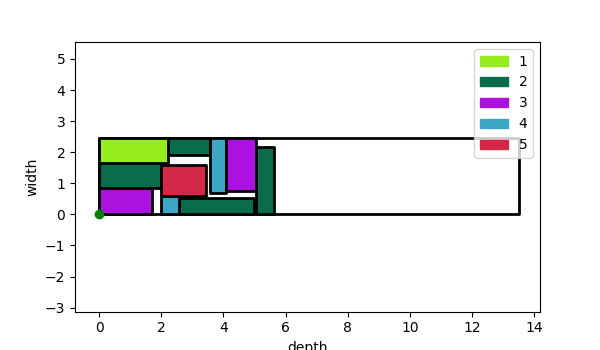

In [101]:
for i in range(1):
    items,bins=tc_sfida()
    model = model_bin_packing(items,bins)
    s,t,w,d,h,n=model.buildModel()
    s.computeObj()
    mod_obj.append(s.obj)
    eu_obj.append(euristic(items,bins))
    Time.append(round(t,3))
    n_items.append(n)
    feasible.append(isfeasibleorder(s))
    BP_plot.plotSolution(s)

In [76]:
dimensioni =pd.DataFrame({'n_items': n_items, 'Eu obj': eu_obj,'Mod obj': mod_obj, 'Time': Time,'Feasible': feasible})

In [80]:
dimensioni.to_excel('istanza.xlsx', encoding='utf8')

In [78]:
dimensioni

,Eu obj,Feasible,Mod obj,Time,n_items
0,4.778627,1,4.303665,303.155,10
1,3.429958,1,3.429958,2.481,5
2,5.610036,1,5.039148,303.439,10
3,4.993233,1,4.264608,302.756,9
4,3.694374,1,2.777999,1.416,5
5,4.583702,1,4.225645,66.250,7
6,5.297026,1,4.843391,302.065,9
7,4.806558,1,4.514774,302.217,9
8,2.934668,1,2.124153,0.033,3
9,4.654115,1,3.746243,300.763,9


In [79]:
send_mail()